In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import networkx as nx

from coppeliasim_zmqremoteapi_client import RemoteAPIClient

In [4]:
client = RemoteAPIClient()
sim = client.require('sim')

In [5]:
def Rz(theta):
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                     [ np.sin(theta), np.cos(theta) , 0 ],
                     [ 0            , 0             , 1 ]])

# Roadmap

In [12]:
def calcHolonomicVelocity(theta:float, gain:np.ndarray, error:np.ndarray, Mdir:np.ndarray) -> np.ndarray:
    """
    Função destinada a calcular a velocidade que será aplicada a cada roda
    :param theta: rotação do robo em radianos
    :param gain: uma matriz 3 x 3 com o ganho que desejamos ter em cada eixo (X, Y, Theta)
    :param error: uma matriz 1 x 3 que mostra o quanto o robo está distante da posição final
    :param Mdir: matriz ..........................................................................................................................
    :return: um vetor com a velocidade que será aplicada sobre cada roda
    """
    qdot = gain @ error

    Minv = np.linalg.inv(Rz(theta) @ Mdir)
    return Minv @ qdot

def moveHolonomicWheels(wheels:list, u:list) -> None:
    """
    Função destinada a movimentar o robo
    :param wheels: lista com os handles de cada roda
    :param u: lista com a velocidade que será aplicada sobre cada roda
    :return: None
    """
    for wheel, v in zip(wheels, u):
        sim.setJointTargetVelocity(wheel, v)
    
def holonomicControl(goal:np.ndarray, gain:np.ndarray, breakDist:float = 0.05) -> None:
    """
    Função destinada a levar o robo até certa posição
    :param goal: uma matriz 1 x 3 com as coordenadas que desejamos alcançar
    :param gain: uma matriz 3 x 3 com o ganho que desejamos ter em cada eixo (X, Y, Theta)
    :param breakDist: distância mínima aceitável para parada
    :return: None
    """
    # obtemos handles do robo e suas rodas
    robot = sim.getObject('/robotino')
    wheels = [sim.getObject(f'/robotino/wheel{i}_joint') for i in range(1,4)]

    # define as constantes que usaremos
    L = 0.135
    r = 0.4
    Mdir = np.array([[-r/np.sqrt(3) , 0        , r/np.sqrt(3)],
                     [ r/3          , (-2*r)/3 , r/3         ], 
                     [ r/(3*L)      , r/(3*L)  , r/(3*L)     ]])

    while True:
        # pegamos a posição e orientação naquele momento
        pos = sim.getObjectPosition(robot)        
        ori = sim.getObjectOrientation(robot)
        q = np.array([pos[0], pos[1], ori[2]])
        
        error = goal - q
        
        # Margem aceitável de distância
        if (np.linalg.norm(error[:2]) < breakDist):
            break

        u = calcHolonomicVelocity(q[2], gain, error, Mdir)

        moveHolonomicWheels(wheels, u)

In [53]:
def openMapImage(imgPath):
    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')
    
    # Invertendo os valores para visualização (Branco - 0, Preto - 1)
    img = 1 - mpimg.imread(imgPath)
    
    # Apenas para garantir que só teremos esses dois valores
    threshold = 0.5
    img[img > threshold] = 1
    img[img<= threshold] = 0
    
    ax.imshow(img, cmap='Greys', origin='upper')

In [57]:
def drawGridLines(mapDimension, cell_size = 2):
    # Dimensões do mapa informado em metros (X, Y)
    map_dims = np.array(mapDimension)
    
    # Escala Pixel/Metro
    sy, sx = img.shape / map_dims
    
    rows, cols = (map_dims / cell_size).astype(int)
    grid = np.zeros((rows, cols))
    
    # Preenchendo o Grid
    # Cada célula recebe o somatório dos valores dos Pixels
    for r in range(rows):
        for c in range(cols):
            
            xi = int(c*cell_size*sx)
            xf = int(xi + cell_size*sx)
            
            yi = int(r*cell_size*sy)
            yf = int(yi + cell_size*sy)
                          
            grid[r, c] = np.sum(img[yi:yf,xi:xf])
            
    # Binarizando as células como Ocupadas (1) ou Não-ocupadas (0)       
    grid[grid > threshold] = 1
    grid[grid<= threshold] = 0        
    
    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')
    
    # Plotando Mapa e Células
    obj = ax.imshow(img, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
    obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)
    
    # Plotando as linhas do grid para facilitar a visualização
    ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
    ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
    ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

In [58]:
def createGraph():
    # Criando vértices em todas as células
    G = nx.grid_2d_graph(rows, cols) 
    
    # Removendo células que estão em células marcas com obstáculos
    for r in range(rows):
        for c in range(cols):
            if grid[r][c] == 1:  
                G.remove_node((r,c))
    
    
    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')
    
    # Grid
    obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]))
    
    ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
    ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
    ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))
    
    # Os vértices serão plotados no centro da célula  
    pos = {node:(node[1]*cell_size+cell_size/2, map_dims[0]-node[0]*cell_size-cell_size/2) for node in G.nodes()}
    nx.draw(G, pos, font_size=3, with_labels=True, node_size=50, node_color="g", ax=ax)

In [75]:
def chooseBestPath(start_node, end_node):
    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')
    
    # Mapa
    obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))
    
    # Caminho
    path = nx.shortest_path(G, source=start_node, target=end_node)
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=50, node_color='b')

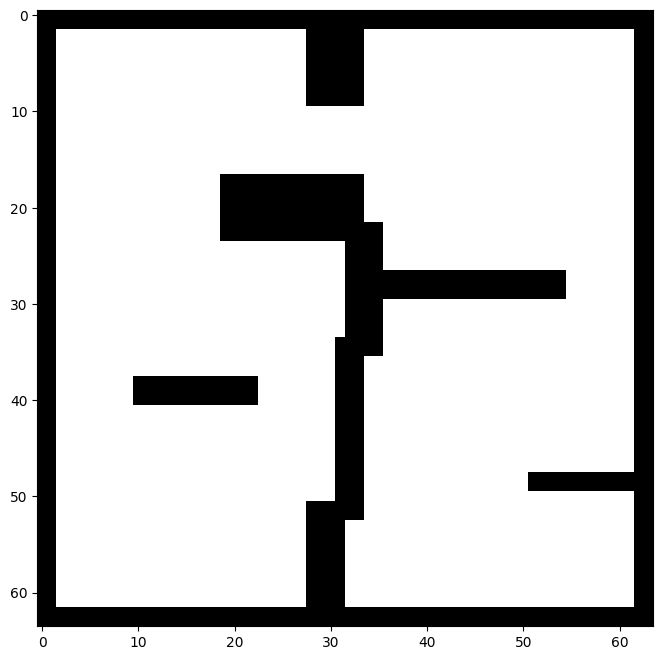

In [54]:
openMapImage('img/mapa.png')

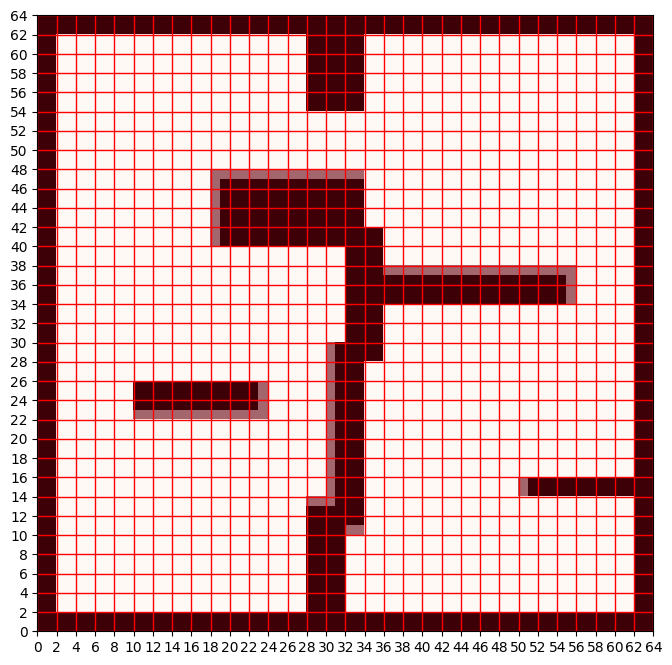

In [64]:
drawGridLines([64, 64])

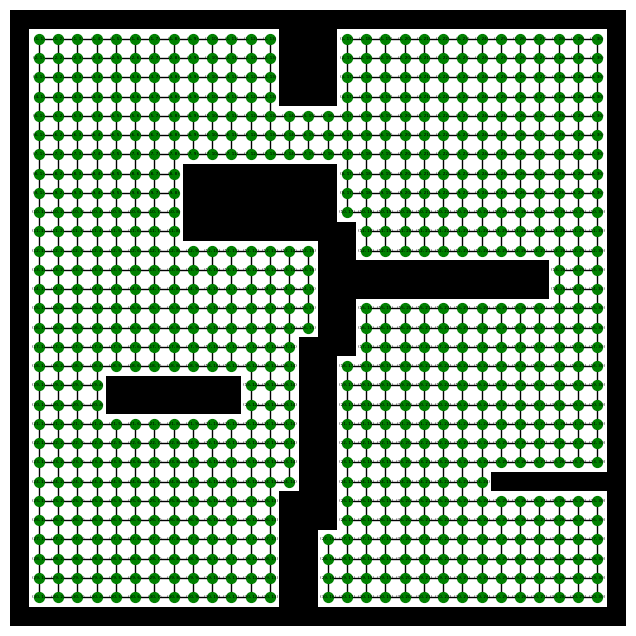

In [65]:
createGraph()

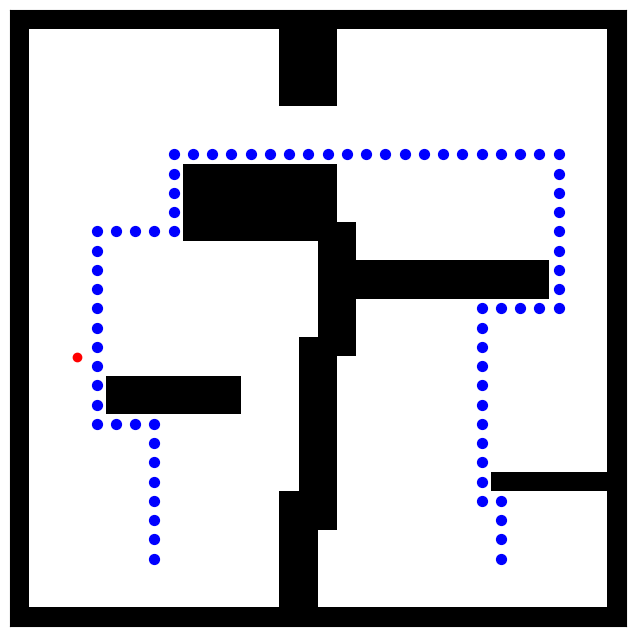

In [76]:
start_node =  (28, 7)
end_node = (28, 25)

chooseBestPath(start_node, end_node)

# Potential Fields

In [23]:
def buildHomogeneousMatrix(rotationMatrix:np.ndarray, translationMatrix:np.ndarray) -> np.ndarray:
    """
    Função destinada a montar a matriz de tranformação homogenea
    :param rotationMatrix: matriz de rotação
    :param translationMatrix: matriz de translação
    :return: retorna a matriz de transformação homogênea
    """
    upperRows = np.concatenate([rotationMatrix, translationMatrix], axis = 1)
    lowerRow = np.array([[0, 0, 0, 1]])
    
    return np.concatenate([upperRows, lowerRow], axis = 0)

def transform(robotPosition:np.ndarray, robotOrientation:np.ndarray, objectPosition:np.ndarray) -> np.ndarray:
    """
    Função destinada a realizar a transformação de um ponto para o referencial do robô
    :param robotPosition: vetor de posição do robô
    :param robotOrientation: vetor de orientação do robô
    :param objectPosition: vetor de posição do objeto
    :return: vetor de posição do objeto sobre o referecial do robô
    """
    rotation = Rz(robotOrientation[2]).T
    translation = rotation @ -robotPosition.T

    homoMatrix = buildHomogeneousMatrix(rotation, translation)
    objectPosition = np.concatenate([objectPosition, np.array([[1]])], axis = 1)

    return homoMatrix @ objectPosition.T

def reverseTransform(robotPosition:np.ndarray, robotOrientation:np.ndarray, objectPosition:np.ndarray) -> np.ndarray:
    """
    Função destinada a realizar a transformação de um ponto para o referencial do robô
    :param robotPosition: vetor de posição do robô
    :param robotOrientation: vetor de orientação do robô
    :param objectPosition: vetor de posição do objeto
    :return: vetor de posição do objeto sobre o referecial do robô
    """
    rotation = Rz(robotOrientation[2])
    translation = robotPosition.T

    homoMatrix = buildHomogeneousMatrix(rotation, translation)
    objectPosition = np.concatenate([objectPosition, np.array([[1]])], axis = 1)

    return homoMatrix @ objectPosition.T

def readSensorData(range_data_signal_id="hokuyo_range_data", 
                    angle_data_signal_id="hokuyo_angle_data"):

    # the first call should be non-blocking to avoid getting out-of-sync angle data
    string_range_data = sim.getStringSignal(range_data_signal_id)
    string_angle_data = sim.getStringSignal(angle_data_signal_id)

    # check the if both data were obtained correctly
    if string_range_data and string_angle_data :
        # unpack data from range and sensor messages
        raw_range_data = np.array(sim.unpackFloatTable(string_range_data))
        raw_angle_data = np.array(sim.unpackFloatTable(string_angle_data))

        return raw_range_data, raw_angle_data

    # return none in case were nothing was gotten from the simulator
    return None, None

def transformSensorData(dist:float, angle:float) -> tuple:
    """
    Função destinada a transformar os dados retornados pelo sensor para coordenadas X, Y
    :param dist: distância do objeto para o robô
    :param angle: angûlo do objeto em relação ao robô
    :return: as coordenadas X, Y de um objeto segundo o referencial do robô
    """
    x = dist * np.cos(angle)
    y = dist * np.sin(angle)
    return x, y

In [24]:
def attraction(goal:np.ndarray, katt:float=.01) -> np.ndarray:
    """
    Função destinada a calcular a força de atração que está atuando sobre nosso robô
    :param goal: posição do objetivo sob o referencial do robô (X, Y)
    :param katt: constante de atração
    :return: um vetor indicando a força de atração que atua sobre o robô
    """
    return katt * goal

def repulsion(obs:np.ndarray, theta:float, R:float=3, krep:float=.1) -> np.ndarray:
    """
    Função destinada a calcular a força de repulsão que um obstáculo exerce robô
    :param obs: posição do obstáculo sob o referencial do robô (X, Y, Theta)
    :param R: ...........................................................................................
    :param katt: constante de repulsão
    :return: um vetor indicando a força de repulsão que o obstáculo exerce robô
    """
    v = -obs
    d = np.linalg.norm(v, axis=1) - theta
    d = d.reshape((len(v) ,1))
    
    rep = (1/d**2)*((1/d)-(1/R))*(v/d)    
    
    invalid = np.squeeze(d > R)
    rep[invalid, :] = 0
    
    return krep * rep

In [25]:
def calcNonHolonomicVelocity(fx:float, fy:float, theta:float, 
                             maxv:float = 1, maxw:float = np.deg2rad(45),
                             kr:float = 1, kt:float = 2) -> tuple:
    """
    Função destinada a calcular as velocidades que serão aplicadas sobre o robo
    :param fx: força aplica sobre o eixo X
    :param fy: força aplica sobre o eixo Y
    :param theta: rotação do robo em radianos
    :param maxv: velocidade máxima que desejamos empregar ao robo
    :param maxw: ângulo máximo que desejamos ser capaz de rotacionar o robo
    :param kr: constante aplicada ao cálculo da velociade
    :param kt: constante aplicada ao cálculo da rotação
    :return: velocidade linear e angular
    """
    v = kr*(fx*np.cos(theta) + fy*np.sin(theta))
    w = kt*(np.arctan2(fy,fx) - theta)

    # Limit v,w to +/- max
    v = max(min(v, maxv), -maxv)
    w = max(min(w, maxw), -maxw)        
    
    return v, w

def moveNonHolonomicWheels(leftWheel:int, rightWheel:int, v:float, w:float, L:float, r:float) -> None:
    """
    Função destinada a mover as rodas do robo 
    :param rightWheel: handle para o motor da roda direita
    :param leftWheel: handle para o motor da roda esquerda
    :param v: velocidade linear
    :param w: velocidade angular
    :param L: largura do eixo (em metros)
    :param r: raio roda (em metros)
    :return: None
    """
    vl = ((2.0*v) - (w*L))/(2.0*r)
    vr = ((2.0*v) + (w*L))/(2.0*r)
        
    sim.setJointTargetVelocity(leftWheel, vl)
    sim.setJointTargetVelocity(rightWheel, vr)

def stopNonHolonomicWheels() -> None:
    """
    Função destinada a para o robo
    :param: None
    :return: None
    """
    robotname = '/Pioneer_p3dx'
    leftWheel  = sim.getObject(f"{robotname}{robotname}_leftMotor")
    rightWheel = sim.getObject(f"{robotname}{robotname}_rightMotor")

    sim.setJointTargetVelocity(leftWheel, 0)
    sim.setJointTargetVelocity(rightWheel, 0)

def nonHolonomicControl(fx:float, fy:float, theta:float, leftWheel:int, rightWheel:int) -> None:
    """
    Função destinada a levar o robo até certa posição
    :param goal: 
    :param gain: 
    :param maxv: velocidade máxima que desejamos empregar ao robo
    :param maxw: ângulo máximo que desejamos ser capaz de rotacionar o robo
    :param kr: constante aplicada ao cálculo da velociade
    :param kt: constante aplicada ao cálculo da rotação
    :return: None
    """
    # Específico do robô
    L = 0.381
    r = 0.0975

    maxv = 1
    maxw = np.deg2rad(45)

    kr = 1
    kt = 2
    
    # move o robô
    v, w = calcNonHolonomicVelocity(fx, fy, theta, maxv, maxw, kr, kt)
    moveNonHolonomicWheels(leftWheel, rightWheel, v, w, L, r)

In [26]:
try:
    # obtemos a posição do nosso goal
    goal = sim.getObject('/ReferenceFrame')
    goal = np.array([sim.getObjectPosition(goal)])

    # define o raio de visão que iremos considerar do robô
    R = 1.5
    # coleta os handles do robô
    robotname = '/Pioneer_p3dx'
    robot = sim.getObject(robotname)    
    leftWheel  = sim.getObject(f"{robotname}{robotname}_leftMotor")
    rightWheel = sim.getObject(f"{robotname}{robotname}_rightMotor")


    sim.startSimulation()
    time.sleep(2)

    rho = np.inf
    while True:
        robotPos = np.array([sim.getObjectPosition(robot)])
        robotOri = np.array(sim.getObjectOrientation(robot))

        qGoal = transform(robotPos, robotOri, goal).T[0,:2]

        if np.linalg.norm(qGoal) < 0.1:
            stopNonHolonomicWheels()
            break

        dist, angle = readSensorData()

        finds = dist <= R
        dist = dist[finds]
        angle = angle[finds]

        x, y = transformSensorData(dist, angle)
        xy = np.dstack([x, y]).reshape(-1, 2)

        F_att = attraction(qGoal, .06)
        fx, fy = F_att

        if np.any(finds):
            F_rep = repulsion(xy, 0, krep=0.01)
            fx += F_rep[:, 0].sum()
            fy += F_rep[:, 1].sum()

        nonHolonomicControl(fx, fy, 0, leftWheel, rightWheel)

    sim.stopSimulation()
finally:
    stopNonHolonomicWheels()